In [1]:
import torch
import h5py
import sys
import subprocess
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.distributions import Normal
import numpy as np
import argparse
import time
from helpers import timeSince, asMinutes
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import roc_curve, auc

from baseline_model import *


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
data_fn = '/n/data_02/Basset/data/mini_roadmap.h5'

start = time.time()
print("Reading data from file {}".format(data_fn))
data = h5py.File(data_fn)

#train = torch.utils.data.TensorDataset(torch.CharTensor(data['train_in']), torch.CharTensor(data['train_out']))
val = torch.utils.data.TensorDataset(torch.CharTensor(data['valid_in']), torch.CharTensor(data['valid_out']))
test = torch.utils.data.TensorDataset(torch.CharTensor(data['test_in']), torch.CharTensor(data['test_out']))
#train_loader = torch.utils.data.DataLoader(train, batch_size=args.batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=100, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=100, shuffle=False)
print("Dataloaders generated {}".format( timeSince(start) ))
start = None


Reading data from file /n/data_02/Basset/data/mini_roadmap.h5
Dataloaders generated 0m 39s


In [15]:
model_fn = 'basset.pkl'
print("Import model from {}".format(model_fn))

model = Basset()
model.load_state_dict(torch.load(model_fn))
print("Done")

Import model from basset.pkl
Done


In [16]:
val_tensor = to_one_hot(torch.FloatTensor(data['valid_in'][()].astype('uint8')), n_dims=4).permute(0,3,1,2).squeeze().float()

In [17]:
model.cuda()
model.eval()
val_tensor = val_tensor.cuda()
val_tensor.shape

torch.Size([70000, 4, 600])

In [18]:
val_set = []
slice_size = 1000
for i in range(int(val_tensor.shape[0] / slice_size)):
    start_index = i*slice_size
    stop_index  = (i+1)*slice_size
    val_set.append( model( val_tensor[start_index:stop_index] ).cpu().data.numpy() )
val_set = np.row_stack(val_set)

In [19]:
val_set.shape

(70000, 164)

In [ ]:
np.set_printoptions(threshold=np.nan)

In [ ]:
inputs, targets = val_tensor[100:200], data['valid_out'][100:200][()]

In [ ]:
inputs.shape

In [ ]:
threshold = 0.5
preds = (F.sigmoid(model( inputs )).cpu().data.numpy() > threshold).astype(int)
matches = np.sum(preds == targets)
tru_pos = np.sum(matches == targets) / np.sum(targets)
fls_pos = np.sum( (not matches) == targets ) / np.sum(targets == 0)


In [ ]:
np.sum(matches == targets)

In [ ]:
threshold = 0.5
for inputs, targets in val_loader:
    preds = (F.sigmoid(model( inputs )).cpu().data.numpy() > threshold).astype(int)
    matches = np.sum(preds == targets)
    tru_pos = np.sum(matches == targets) / np.sum(targets)
    fls_pos = np.sum( (not matches) == targets ) / np.sum(targets == 0)


In [20]:
n_classes = 164
y_test = data['valid_out'][()]
y_score= val_set
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

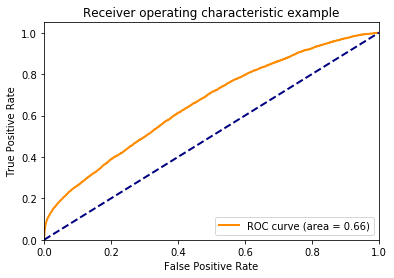

In [21]:
plt.figure()
lw = 2
type_idx = 120
plt.plot(fpr[type_idx], tpr[type_idx], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[type_idx])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [22]:
roc_auc

{0: 0.7618613171394464,
 1: 0.5746849714086869,
 10: 0.725108025269788,
 100: 0.582874531112661,
 101: 0.5667001793253024,
 102: 0.5559356331684404,
 103: 0.5438404384776613,
 104: 0.538140643269763,
 105: 0.49905166375959076,
 106: 0.723943508240313,
 107: 0.6701109797866034,
 108: 0.6143247539802602,
 109: 0.5539347706238449,
 11: 0.7292492375648681,
 110: 0.5499123776228707,
 111: 0.6337303171576795,
 112: 0.6408774102049679,
 113: 0.7462484249293257,
 114: 0.6276167696498571,
 115: 0.7233176731409388,
 116: 0.647974111453386,
 117: 0.5873321492199391,
 118: 0.6417531840728051,
 119: 0.6250970331929184,
 12: 0.6933024927311117,
 120: 0.6588383523785709,
 121: 0.6182235897307597,
 122: 0.6252087805136852,
 123: 0.6347328154299839,
 124: 0.7083711014155659,
 125: 0.5502201349889113,
 126: 0.6757244971041048,
 127: 0.683853981387107,
 128: 0.6827228036749657,
 129: 0.6865055631534278,
 13: 0.7332985773042573,
 130: 0.7020898605563763,
 131: 0.614947733631925,
 132: 0.6251978272020682,
